In [1]:
#%mkdir data
#%mkdir data/person

#!wget --no-check-certificate https://archive.ics.uci.edu/ml/machine-learning-databases/00196/ConfLongDemo_JSI.txt
#%mv ConfLongDemo_JSI.txt data/person/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GraduateSchool/NeuralODE/midterm_assignment

Mounted at /content/drive
/content/drive/MyDrive/GraduateSchool/NeuralODE/midterm_assignment


In [3]:
# Copyright 2021 The ODE-LSTM Authors. All Rights Reserved.
import os
import tensorflow as tf
import argparse
from irregular_sampled_datasets import PersonData
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = PersonData()

all_x.shape:  (9711, 32, 7)
all_t.shape:  (9711, 32, 1)
all_y.shape:  (9711, 32)
Total number of sequences: 9711
train_x.shape:  (7769, 32, 7)
train_t.shape:  (7769, 32, 1)
train_y.shape:  (7769, 32)
Total number of train sequences: 7769
Total number of test  sequences: 1942


### 2. LSTMCell
* time 정보 x input으로 활용
* augmented lstm

In [5]:
class LSTMCell(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = (units, units)
        self.initializer = "glorot_uniform"
        self.recurrent_initializer = "orthogonal"
        super(LSTMCell, self).__init__(**kwargs)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        return (
            tf.zeros([batch_size, self.units], dtype=tf.float32),
            tf.zeros([batch_size, self.units], dtype=tf.float32),
        )

    def build(self, input_shape):
        if isinstance(input_shape[0], tuple):
            # 저자의 코드에서는 multi input이 되어 (Nested tuple) 아래읭 코드가 성공적으로 돌아갔다.
            # 하지만 multi input이 현재 인식이 안되어 input_shape[1] 이 none이라 error가 발생한다.
            #input_shape = (input_shape[0][-1] + input_shape[1][-1],)
            input_shape = (input_shape[0][-1],)

        self.input_kernel = self.add_weight(
            shape=(input_shape[-1], 4 * self.units),
            initializer=self.initializer,
            name="input_kernel",
        )
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, 4 * self.units),
            initializer=self.recurrent_initializer,
            name="recurrent_kernel",
        )
        self.bias = self.add_weight(
            shape=(4 * self.units,),
            initializer=tf.keras.initializers.Zeros(),
            name="bias",
        )

        self.built = True

    def call(self, inputs, states):
        cell_state, output_state = states

        # 주석 처리된 부분은 저자의 코드와 다른 부분이다.
        # 시간 정보를 data input에 넣었기 때문에 input을 나누는 조정을 시행하지 않았다.
        # if (isinstance(inputs, tuple) or isinstance(inputs, list)) and len(inputs) > 1:
        #     inputs = tf.concat([inputs[0], inputs[1]], axis=-1)

        z = (
            tf.matmul(inputs, self.input_kernel)
            + tf.matmul(output_state, self.recurrent_kernel)
            + self.bias
        )
        i, ig, fg, og = tf.split(z, 4, axis=-1)

        input_activation = tf.nn.tanh(i)
        input_gate = tf.nn.sigmoid(ig)
        forget_gate = tf.nn.sigmoid(fg + 1.0)
        output_gate = tf.nn.sigmoid(og)

        new_cell = cell_state * forget_gate + input_activation * input_gate
        output_state = tf.nn.tanh(new_cell) * output_gate

        return output_state, [new_cell, output_state]

In [6]:
def train_model():
    # 모델 입력 정의
    pixel_input = tf.keras.Input(shape=(data.seq_len, data.feature_size), name="features")
    time_input = tf.keras.Input(shape=(data.seq_len, 1), name="time")

    # concatLayer 정의
    # 저자가 제공하는 lstm 코드에서는 call 부분에서 concat을 진행하였지만 현재 tensorflow rnn이 tuple 형태의 multi-input이 안되어 미리 병합하는 layer를 정의한다.
    class concatLayer(tf.keras.layers.Layer):
        def call(self, x, y):
            concat = tf.concat([x, y], axis=-1)  # (None, seq_len, feature_size + 1)
            return concat  # (None, seq_len, 8)

    # 입력 병합
    inputs = concatLayer()(pixel_input, time_input)

    # RNN 및 Dense Layer 설정
    rnn = tf.keras.layers.RNN(LSTMCell(units=64), return_sequences=True)
    dense_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(data.num_classes))

    # 모델 아키텍처
    output_states = rnn(inputs)
    y = dense_layer(output_states)

    model = tf.keras.Model(inputs=[pixel_input, time_input], outputs=[y])
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # 모델 훈련 및 평가
    hist = model.fit(
        x=(data.train_x, data.train_t),
        y=data.train_y,
        batch_size=128,
        epochs=200,
        validation_data=((data.test_x, data.test_t), data.test_y),
    )
    _, best_test_acc = model.evaluate(
        x=(data.test_x, data.test_t), y=data.test_y, verbose=2
    )

    return model, hist,best_test_acc

In [ ]:
model_1, hist_1, best_test_acc_1 = train_model()
print("1 끝")
model_2, hist_2, best_test_acc_2 = train_model()
print("2 끝")
model_3, hist_3, best_test_acc_3 = train_model()
print("3 끝")
model_4, hist_4, best_test_acc_4 = train_model()
print("4 끝")
model_5, hist_5, best_test_acc_5 = train_model()
print("5 끝")

Epoch 1/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 1.6682 - sparse_categorical_accuracy: 0.3652 - val_loss: 1.4657 - val_sparse_categorical_accuracy: 0.4088
Epoch 2/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2238 - sparse_categorical_accuracy: 0.5287 - val_loss: 1.2256 - val_sparse_categorical_accuracy: 0.5397
Epoch 3/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0312 - sparse_categorical_accuracy: 0.5979 - val_loss: 0.9624 - val_sparse_categorical_accuracy: 0.6171
Epoch 4/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8826 - sparse_categorical_accuracy: 0.6667 - val_loss: 0.7852 - val_sparse_categorical_accuracy: 0.7130
Epoch 5/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7800 - sparse_categorical_accuracy: 0.7131 - val_loss: 0.8312 - val_sparse_categorical_accuracy: 0.6746
Epoch 6/200
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7256 - sparse_categorical_accuracy: 0.7265 - val_loss: 0.6974 - val_sparse_categorical_accuracy: 0.7419
Epoch 7/2

In [12]:
def plot_hist(hist):
    # history에서 loss, accuracy 값 추출
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    sparse_categorical_accuracy = hist.history['sparse_categorical_accuracy']
    val_sparse_categorical_accuracy = hist.history['val_sparse_categorical_accuracy']

    epochs = range(1, len(loss) + 1)

    # Loss 그래프
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, sparse_categorical_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_sparse_categorical_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

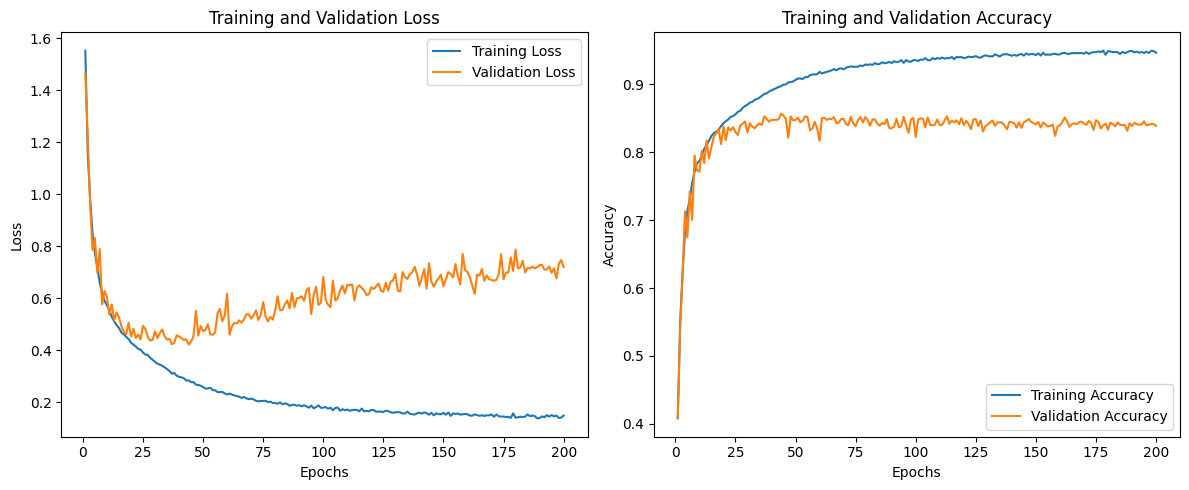

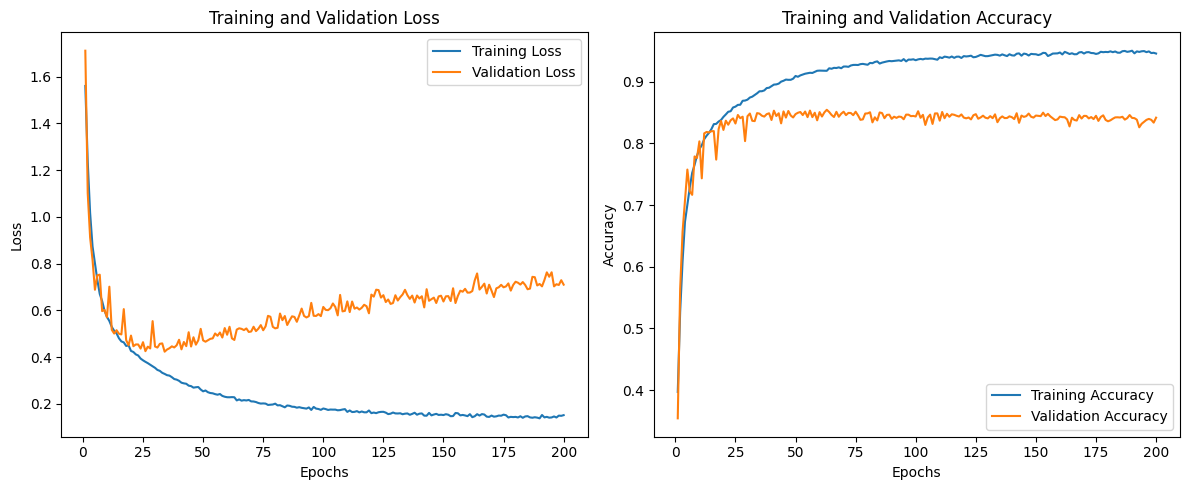

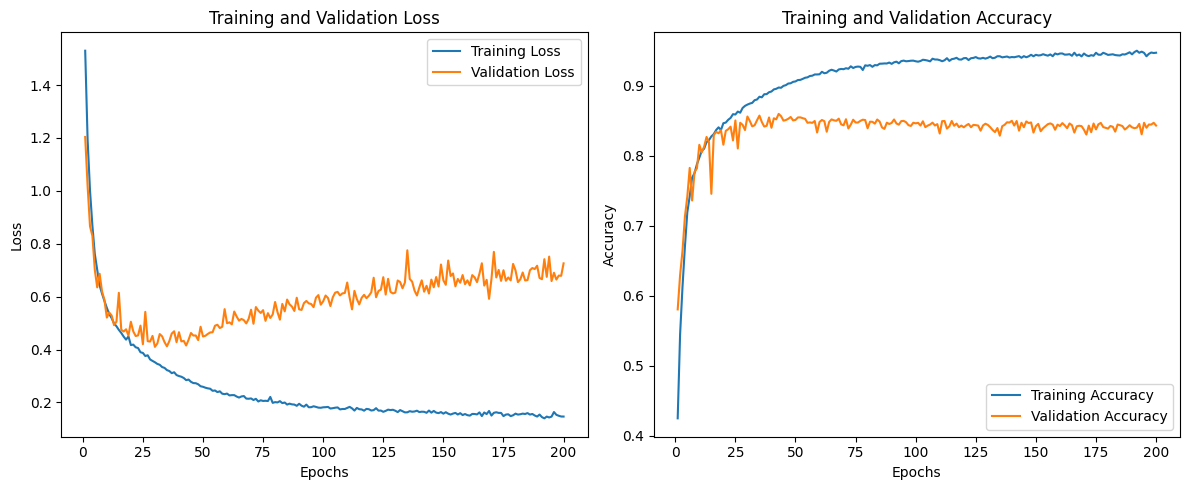

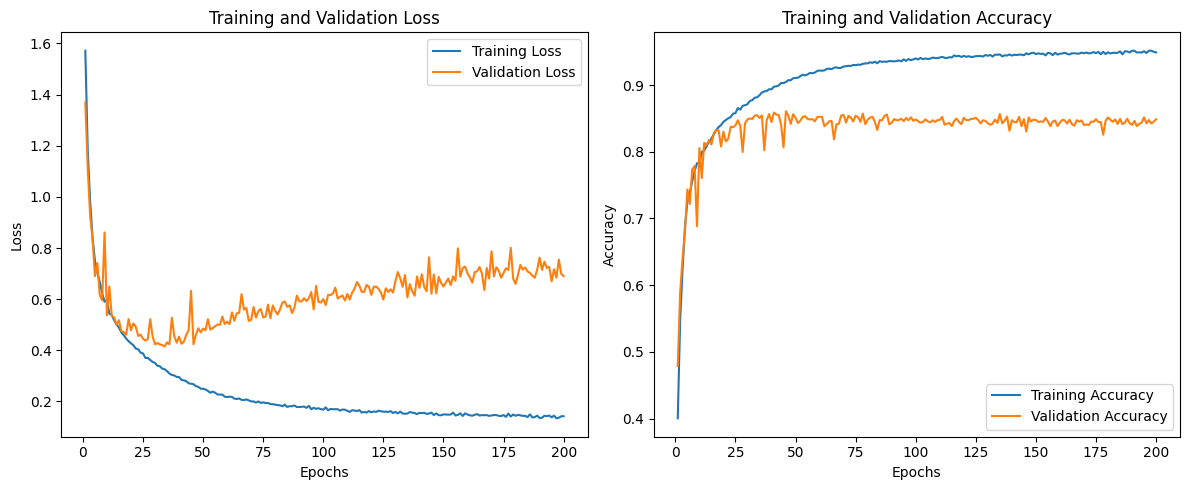

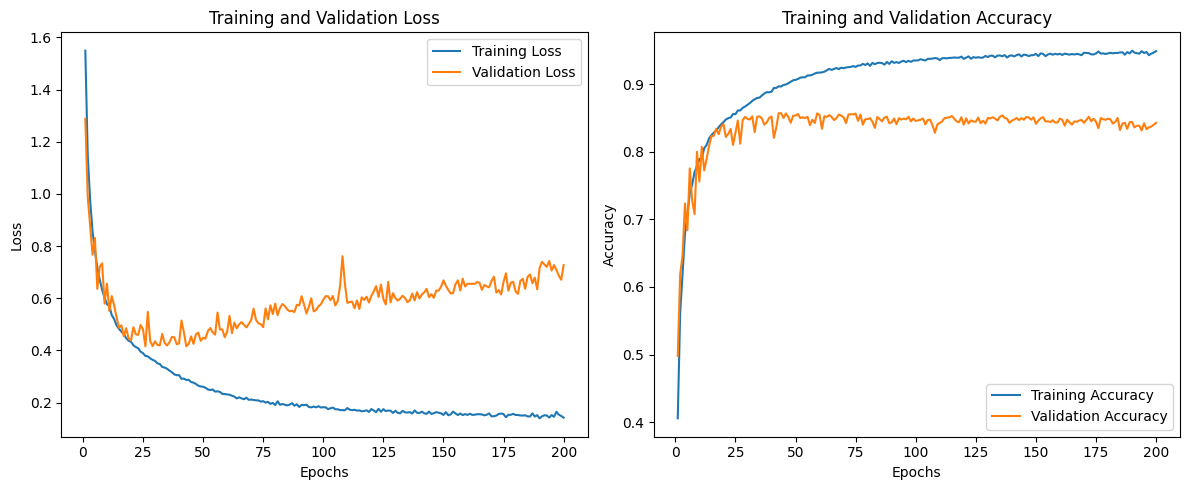

In [13]:
plot_hist(hist_1)
plot_hist(hist_2)
plot_hist(hist_3)
plot_hist(hist_4)
plot_hist(hist_5)

In [11]:
mean = np.mean([best_test_acc_1,  best_test_acc_2, best_test_acc_3, best_test_acc_4, best_test_acc_5])
std = np.std([best_test_acc_1,  best_test_acc_2, best_test_acc_3, best_test_acc_4, best_test_acc_5])

print(f"{mean*100}%, {std*100}")

84.29389715194702%, 0.32028482445169215
